In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load and preprocess data
file_path = "data/transformed_currency_data.csv"
data = pd.read_csv(file_path, sep=",")
data["exchangedate"] = pd.to_datetime(data["exchangedate"])

# Select USD data and drop missing values
usd_data = data[["exchangedate", "USD"]].dropna()
usd_data.set_index("exchangedate", inplace=True)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(usd_data)

# Prepare training and testing datasets
look_back = 30  # Number of past days to consider for prediction


def create_dataset(dataset, look_back):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i : i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)


X, Y = create_dataset(scaled_data, look_back)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

# Train the model
history = model.fit(
    X_train,
    Y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, Y_test),
    verbose=1,
)

# Generate predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse scaling for predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Forecast future values for 2025
future_predictions = []
input_sequence = scaled_data[-look_back:]
input_sequence = input_sequence.reshape(1, look_back, 1)


Epoch 1/20


/Users/yuri/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0207 - val_loss: 7.5259e-04
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.2260e-04 - val_loss: 7.8207e-04
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.2820e-04 - val_loss: 0.0012
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5045e-04 - val_loss: 0.0013
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3678e-04 - val_loss: 7.9991e-04
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.4235e-04 - val_loss: 7.9932e-04
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3626e-04 - val_loss: 0.0013
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1142e-04 - val_loss: 0.0012
Epoch 9/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2679e-04 - val_loss: 6.8048e-04
Epoch 10/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1210e-04 - val_loss: 3.3640e-04
Epoch 11/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5700e-04 - val_l

In [10]:

for _ in range(365):  # Predict for 365 days
    next_prediction = model.predict(input_sequence)
    future_predictions.append(next_prediction[0, 0])
    input_sequence = np.append(
        input_sequence[:, 1:, :], next_prediction.reshape(1, 1, 1), axis=1
    )

# Inverse transform the future predictions
future_predictions = scaler.inverse_transform(
    np.array(future_predictions).reshape(-1, 1)
)

# Prepare dates for future predictions
last_date = usd_data.index[-1]
date_range = pd.date_range(last_date + pd.Timedelta(days=1), periods=365)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

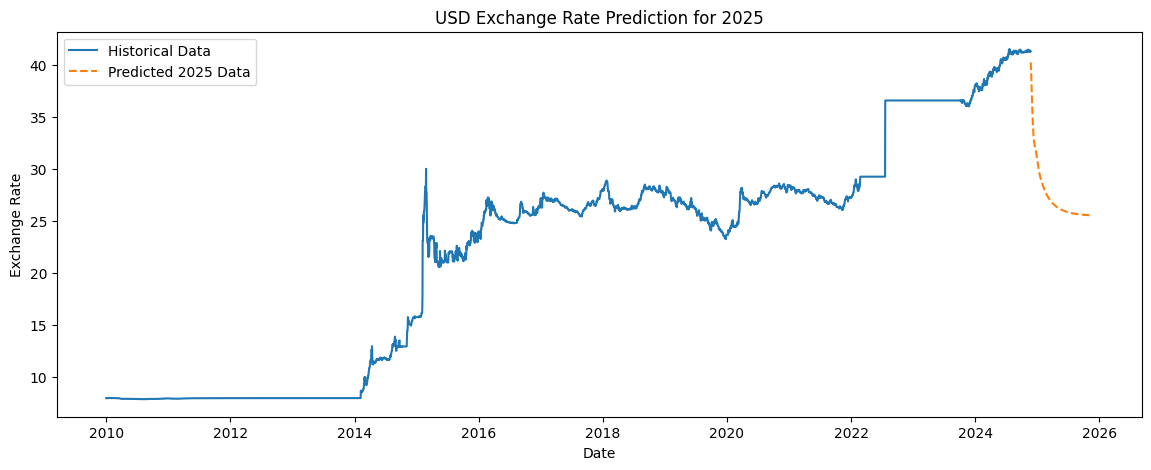

In [11]:

# Ensure future_predictions has the same length as date_range
future_predictions = future_predictions[:365]

# Plot results
plt.figure(figsize=(14, 5))
plt.plot(usd_data.index, usd_data["USD"], label="Historical Data")
plt.plot(date_range, future_predictions, label="Predicted 2025 Data", linestyle="--")
plt.title("USD Exchange Rate Prediction for 2025")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()